<a href="https://colab.research.google.com/github/Raaghashree/Intel-Products-Sentiment-Analysis/blob/main/Vaders_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install necessary modules

In [9]:
pip install googletrans==4.0.0-rc1 langdetect

Upload files to anaylse

In [4]:
from google.colab import files
uploaded = files.upload()

Saving Intel 13th gen data.csv to Intel 13th gen data.csv
Saving Intel 14th gen data.csv to Intel 14th gen data.csv


**Import modules and download packages**

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from langdetect import detect
from googletrans import Translator
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
nltk.download('vader_lexicon')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Choose file to perform analysis on:

In [ ]:
#Replace with different file name if required
df = pd.read_csv("Intel 14th gen data.csv")

VADERS SENTIMENT ANALYSER

In [11]:
sia = SentimentIntensityAnalyzer()
translator = Translator()
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
stop_words.update(['cpu','good','processor','intel','chip','gen','run','pc','used','return','box','new','amazon','issue','day',"don't",'open','great','open','core','got','im','fine','like','didnt','tried','despite','month','case','high'])


Preprocessing Data

In [12]:
print("Size of data:")
print("Before preprocessing:",df.shape)

def preprocessing(df):
    """
    Preprocessing the DataFrame by dropping duplicates, handling NaN values in 'reviewDescription',
    converting text to lowercase, removing stop words, and lemmatizing.
    """
    df.drop_duplicates(subset='reviewId', keep='first', inplace=True)
    df['reviewDescription'].fillna('', inplace=True)
    df['reviewDescription'] = df['reviewDescription'].astype(str).str.lower()

    def clean_text(text):
        text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
        words = nltk.word_tokenize(text)
        words = [word for word in words if word.isalpha()]  # Remove non-alphabetic tokens
        words = [word for word in words if word not in stop_words]  # Remove stop words
        lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
        return ' '.join(lemmatized_words)

    df['reviewDescription'] = df['reviewDescription'].apply(clean_text)
    return df

df = preprocessing(df)
print("After preprocessing:",df.shape)

Size of data:
Before preprocessing: (109, 7)
After preprocessing: (109, 7)


Analysing Sentiment

In [13]:

def detect_and_translate(text):
    try:
        lang = detect(text)
    except:
        lang = 'unknown'

    if lang != 'en':
        try:
            text = translator.translate(text, src=lang, dest='en').text
        except:
            text = ''

    return text

def analyze_sentiment(df):
    res = {}
    positive_comments = []
    negative_comments = []

    for i, row in tqdm(df.iterrows(), total=len(df)):
        text = str(row['reviewDescription'])
        text = detect_and_translate(text)

        scores = sia.polarity_scores(text)
        myid = row['Id']
        res[myid] = scores

        # Store positive and negative comments for feature extraction
        if scores['compound'] >= 0.05:
            positive_comments.append(text)
        elif scores['compound'] <= -0.05:
            negative_comments.append(text)

    return res, positive_comments, negative_comments


res, positive_comments, negative_comments = analyze_sentiment(df)


  0%|          | 0/109 [00:00<?, ?it/s]

Analysed sentiments for the reviews

In [14]:
for myid, scores in res.items():
    print(f"Review ID: {myid}, Sentiment Scores: {scores}")


Review ID: 1, Sentiment Scores: {'neg': 0.0, 'neu': 0.772, 'pos': 0.228, 'compound': 0.6808}
Review ID: 2, Sentiment Scores: {'neg': 0.0, 'neu': 0.478, 'pos': 0.522, 'compound': 0.6659}
Review ID: 3, Sentiment Scores: {'neg': 0.0, 'neu': 0.701, 'pos': 0.299, 'compound': 0.3724}
Review ID: 4, Sentiment Scores: {'neg': 0.115, 'neu': 0.7, 'pos': 0.185, 'compound': 0.34}
Review ID: 5, Sentiment Scores: {'neg': 0.0, 'neu': 0.686, 'pos': 0.314, 'compound': 0.7506}
Review ID: 6, Sentiment Scores: {'neg': 0.0, 'neu': 0.662, 'pos': 0.338, 'compound': 0.6249}
Review ID: 7, Sentiment Scores: {'neg': 0.0, 'neu': 0.929, 'pos': 0.071, 'compound': 0.0772}
Review ID: 8, Sentiment Scores: {'neg': 0.104, 'neu': 0.695, 'pos': 0.201, 'compound': 0.3612}
Review ID: 9, Sentiment Scores: {'neg': 0.197, 'neu': 0.803, 'pos': 0.0, 'compound': -0.4019}
Review ID: 10, Sentiment Scores: {'neg': 0.0, 'neu': 0.154, 'pos': 0.846, 'compound': 0.6705}
Review ID: 11, Sentiment Scores: {'neg': 0.28, 'neu': 0.587, 'pos': 

The updated dataframe

In [15]:

scores_df = pd.DataFrame.from_dict(res, orient='index')
scores_df.index.name = 'Review ID'

vaders = df.merge(scores_df, left_on='Id', right_index=True)
vaders.head()

,Id,reviewId,country,ratingScore,productAsin,reviewTitle,reviewDescription,neg,neu,pos,compound
0,1,R1IMWES2CGSBUC,India,5,B0CGJ9STNF,It's a beast for all kind of works,compare amd ryzen processor easily beat aspect...,0.000,0.772,0.228,0.6808
1,2,R2TERCUI58RK4V,Mexico,5,B0CGJ9STNF,Muy buen procesador,funciona muy bien este procesador estoy satisf...,0.000,0.478,0.522,0.6659
2,3,R2IP7DFHANXOJC,United States,5,B0CGJ9STNF,Couldn't Be Happier,installation first time building nothing went ...,0.000,0.701,0.299,0.3724
3,4,R2F3G4NCXBQLS4,Germany,5,B0CGJ9STNF,Excellent Seller and product,seller posted item delay postal service item b...,0.115,0.700,0.185,0.3400
4,5,R15UREM0WNU4ST,United States,5,B0CGJ9STNF,"Received perfect, good performance.",work looking back get pretty similar performan...,0.000,0.686,0.314,0.7506


Good till here!!!

Extracting Features

In [28]:
def extract_features(comments, n_features=10):

    vectorizer = TfidfVectorizer(max_features=n_features, stop_words='english')
    tfidf_matrix = vectorizer.fit_transform(comments)
    feature_names = vectorizer.get_feature_names_out()
    sums = tfidf_matrix.sum(axis=0)
    data = [(feature_names[col], sums[0, col]) for col in range(sums.shape[1])]
    ranking = pd.DataFrame(data, columns=['feature', 'tfidf']).sort_values(by='tfidf', ascending=False)

    return ranking

positive_features = extract_features(positive_comments)
negative_features = extract_features(negative_comments)

Results of feature analysis and overall product sentiment:

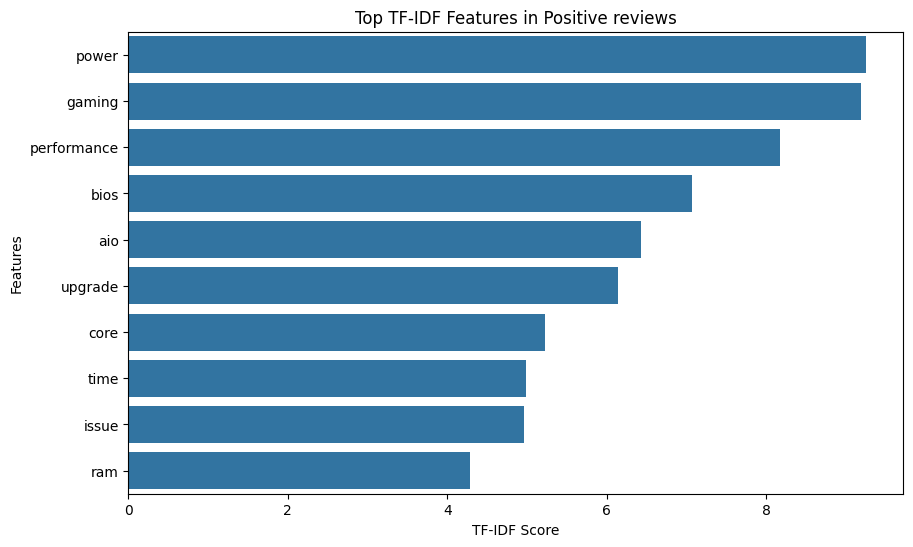

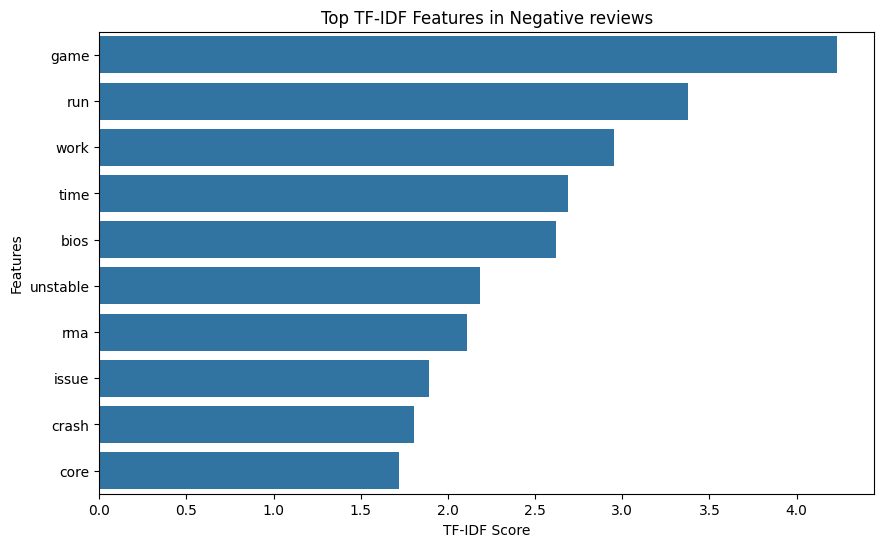

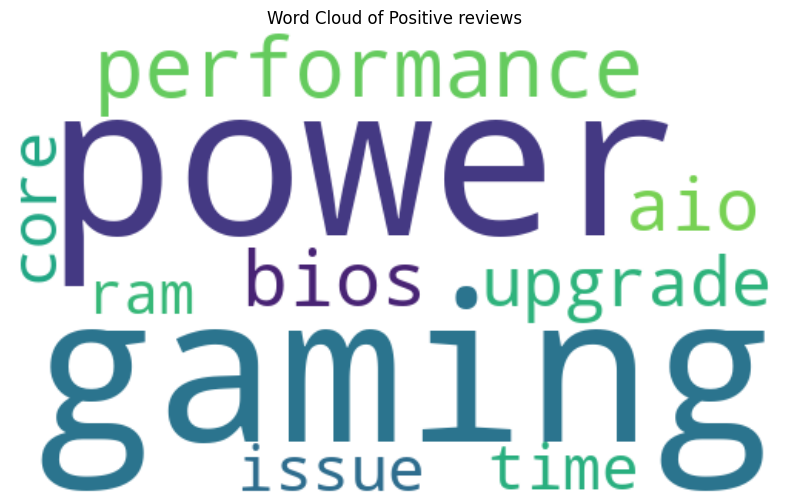

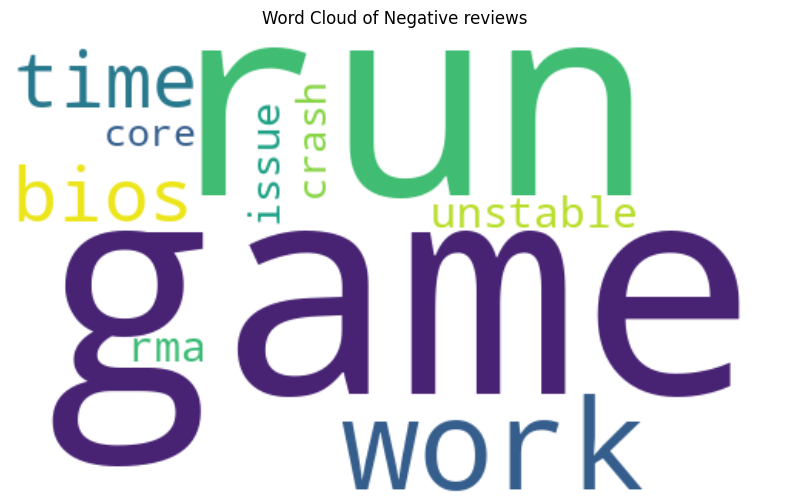

In [32]:
#TF-IDF features positive reviews
plt.figure(figsize=(10, 6))
sns.barplot(x='tfidf', y='feature', data=positive_features)
plt.title('Top TF-IDF Features in Positive reviews')
plt.xlabel('TF-IDF Score')
plt.ylabel('Features')
plt.show()

print("\n" * 3)

#TF-IDF features negative reviews
plt.figure(figsize=(10, 6))
sns.barplot(x='tfidf', y='feature', data=negative_features)
plt.title('Top TF-IDF Features in Negative reviews')
plt.xlabel('TF-IDF Score')
plt.ylabel('Features')
plt.show()

print("\n" * 3)

# Word Cloud Positive reviews
plt.figure(figsize=(10, 6))
wordcloud_pos = WordCloud(width=500, height=300, background_color='white').generate_from_frequencies(dict(positive_features.values))
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Positive reviews')
plt.show()

print("\n" * 3)

# Word Cloud Negative reviews
plt.figure(figsize=(10, 6))
wordcloud_neg = WordCloud(width=500, height=300, background_color='white').generate_from_frequencies(dict(negative_features.values))
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Negative reviews')
plt.show()


Overall sentiment of reviews

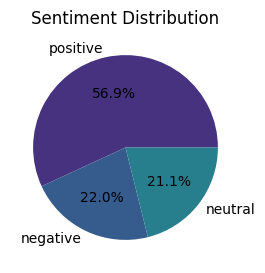

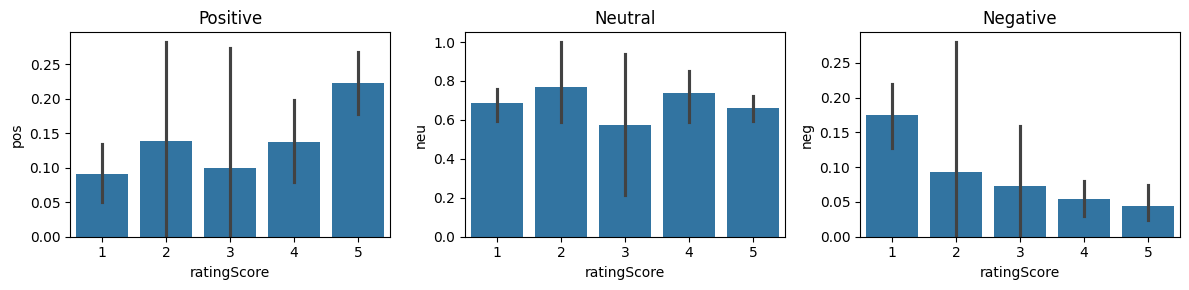

In [25]:
sentiment_counts = vaders['compound'].apply(lambda x: 'positive' if x >= 0.05 else 'negative' if x <= -0.05 else 'neutral')
sentiment_distribution = sentiment_counts.value_counts()
plt.figure(figsize=(4, 3))
plt.pie(sentiment_distribution.values, labels=sentiment_distribution.index, autopct='%1.1f%%', colors=sns.color_palette('viridis'))
plt.title('Sentiment Distribution')
plt.show()

print("\n\n")

fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=vaders, x='ratingScore', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='ratingScore', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='ratingScore', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()

plt.show()

TO BE MODIFIED!!

Evaluating the model performance

In [34]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

X_train, X_test, y_train, y_test = train_test_split(df['reviewDescription'], df['sentiment'], test_size=0.2, random_state=42)

# Vectorize the comments
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Train a simple classifier, for example, Logistic Regression
model = LogisticRegression()
model.fit(X_train_tfidf, y_train)

# Predict on the test set
y_pred = model.predict(X_test_tfidf)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')


KeyError: 'sentiment'